In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px

from sklearn.cluster import KMeans
import tensorflow as tf

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Read the csv
df = pd.read_csv("wtbdata_245days.csv", engine = "pyarrow")

In [8]:
# Expand the Timestamp values into Hour and Minute
df['Hour'] = pd.to_datetime(df['Tmstamp'].astype(str), format='%H:%M:%S').dt.hour
df['Minute'] = pd.to_datetime(df['Tmstamp'].astype(str), format='%H:%M:%S').dt.minute

## Correlation Matrix

In [9]:
# Identify any useful columns for predicting the Patv
px.imshow(df.corr())

#### From the matrix, we can see that `Wspd`, `Pab 1, 2, 3`, and `Prtv` are correlated to `Patv`

In [10]:
# So we just keep these columns
df2 = df[['TurbID', 'Day', 'Hour', 'Minute', 'Wspd', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

<AxesSubplot:>

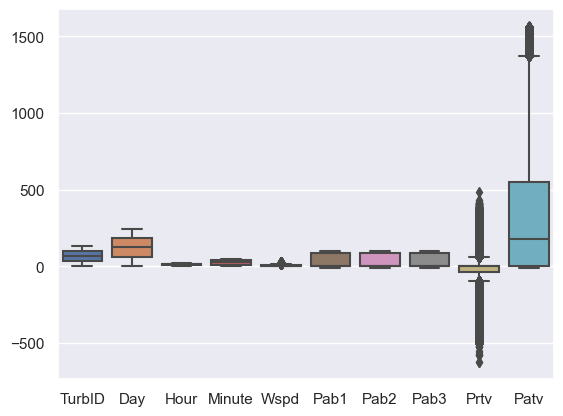

In [11]:
# General view of the data
sns.boxplot(df2)

## Missing, abnormal, and unknown values

In [12]:
# There are some values are missing, abnormal, and unknown

### Conditions:

# Patv<0
# Wspd<1 and Patv>10
# Wspd<2 and Patv>100
# Wspd<3 and Patv>200
# Wspd>2.5 and Patv<=0
# Pab1>89 or Pab2>89 or Pab3>89

# Make an indicator to locate these values
df2['indicator'] = 0

### Analysis on `Pab 1, 2, 3`

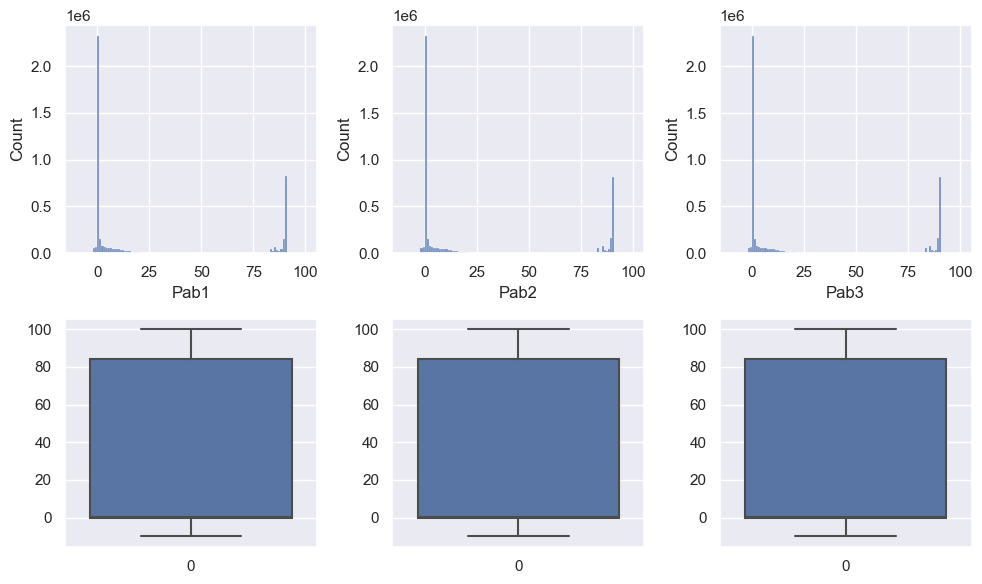

In [13]:
# Show the dsitribution of Pab 1, 2, 3
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(10, 6)
sns.histplot(df2['Pab1'], ax = axes[0, 0])
sns.histplot(df2['Pab2'], ax = axes[0, 1])
sns.histplot(df2['Pab3'], ax = axes[0, 2])

sns.boxplot(df2['Pab1'], ax = axes[1, 0])
sns.boxplot(df2['Pab2'], ax = axes[1, 1])
sns.boxplot(df2['Pab3'], ax = axes[1, 2])

fig.tight_layout()
plt.show()

In [14]:
# Abnormal if Pab1>89 or Pab2>89 or Pab3>89
# Take the max of Pab 1, 2, 3 into Pab_max
df2['Pab_max'] = df2[['Pab1','Pab2','Pab3']].max(axis = 1)
df2.loc[df2['Pab_max'] > 89, 'indicator'] = 1

In [15]:
print("Percentage of abnormal: "+ str(df2['indicator'].value_counts()[1] / len(df2)*100) + '%')

Percentage of abnormal: 20.826881747723966%


### Analysis on `Wspd`

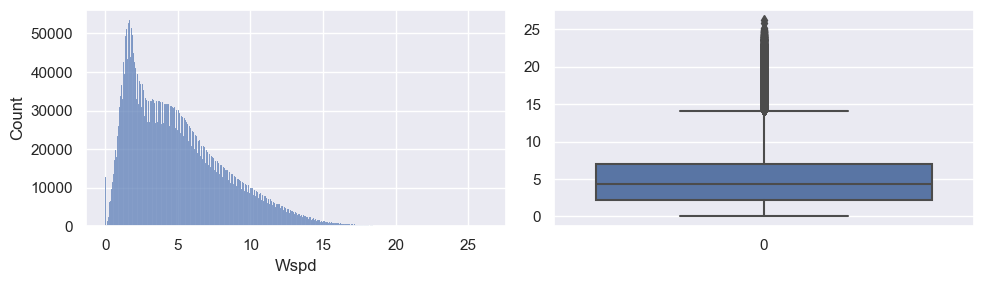

In [16]:
# Show the dsitribution of Wspd
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 3)
sns.histplot(df2['Wspd'], ax = axes[0])
sns.boxplot(df2['Wspd'], ax = axes[1])

fig.tight_layout()
plt.show()

In [17]:
# Wspd<1 and Patv>10
# Wspd<2 and Patv>100
# Wspd<3 and Patv>200
# Wspd>2.5 and Patv<=0

df2.loc[(df2['Patv'] >= 10) & (df2['Wspd'] < 1), 'indicator'] = 1
df2.loc[(df2['Patv'] >= 100) & (df2['Wspd'] < 2), 'indicator'] = 1
df2.loc[(df2['Patv'] >= 200) & (df2['Wspd'] < 3), 'indicator'] = 1
df2.loc[(df2['Patv'] <= 0) & (df2['Wspd'] > 2.5), 'indicator'] = 1

In [18]:
print("Percentage of abnormal: "+ str(df2['indicator'].value_counts()[1] / len(df2)*100) + '%')

Percentage of abnormal: 22.90776136325177%


### Analysis on `Prtv`

In [19]:
# Abnormal if Prtv values are lower than 0
df2.loc[df2['Prtv'] < 0].shape

(3513298, 12)

#### `Prtv` contributes lots of abnormal values.
#### So instead of indicating it's abnormal, we simply change it into zero if it's smaller than zero.

In [20]:
# change it into zero if it's smaller than zero
df2['Prtv'] = df2['Prtv'].apply(lambda x: 0 if x < 0 else x)

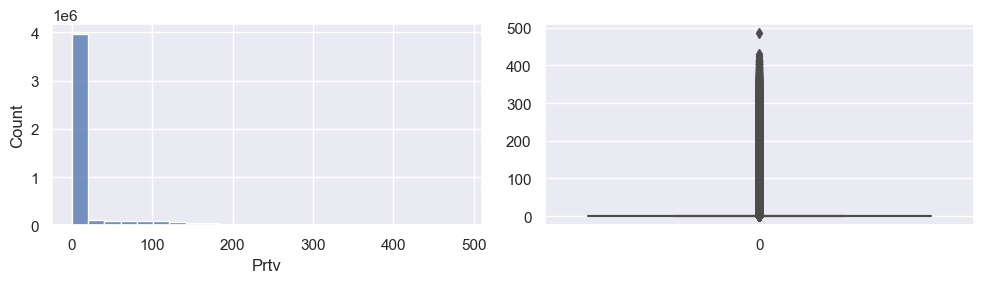

In [21]:
# Show the distribution of Prtv
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 3)
sns.histplot(df2['Prtv'], ax = axes[0])
sns.boxplot(df2['Prtv'], ax = axes[1])

fig.tight_layout()
plt.show()

In [22]:
print("Percentage of abnormal: "+ str(df2['indicator'].value_counts()[1] / len(df2)*100) + '%')

Percentage of abnormal: 22.90776136325177%


### Analysis on `Patv`

In [23]:
# Abnormal if Prtv values are lower than 0
df2.loc[df2['Patv'] < 0].shape

(1263062, 12)

In [24]:
# Do the same as Prtv (change it into zero if it's smaller than zero)
df2['Patv'] = df2['Patv'].apply(lambda x: 0 if x < 0 else x)

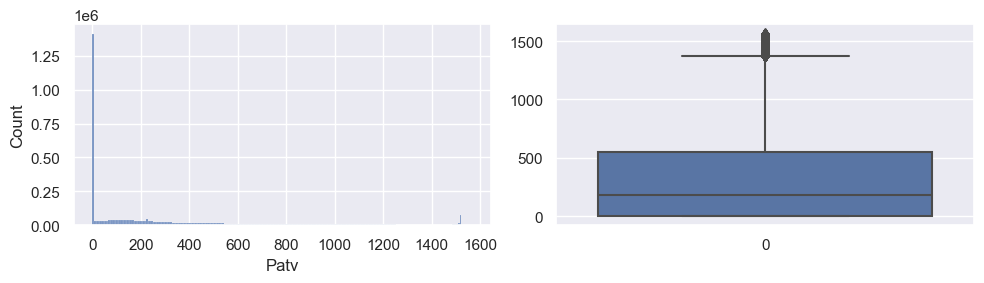

In [25]:
# Show the dsitribution of Patv
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 3)
sns.histplot(df2['Patv'], ax = axes[0])
sns.boxplot(df2['Patv'], ax = axes[1])

fig.tight_layout()
plt.show()

#### We need to investigate the behaviour of `Patv` on different turbine and different time. 

In [26]:
# Group all Patv values by turbines
patv_by_turb = []
for turb in range(df2['TurbID'].nunique()):
    patv_by_turb.append(list(df2[df2['TurbID']==turb+1]['Patv']))
    
patv_df = pd.DataFrame(patv_by_turb)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:27<00:00,  1.51s/it]


Text(0.5, 1.0, 'Elbow Plot')

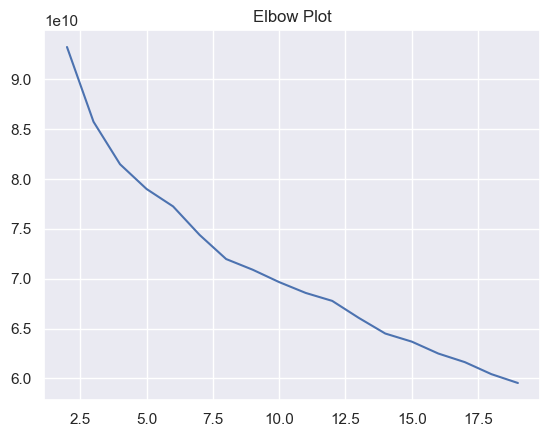

In [27]:
wcss = []
for clus in tqdm(range(2, 20)):
    kmean = KMeans(n_clusters=clus, random_state=42)
    output = kmean.fit(patv_df.fillna(patv_df.mean().mean())) # replace na by overall mean just for clustering 
    wcss.append(output.inertia_)
    
plt.plot(list(range(2, len(wcss)+2)), wcss)
plt.title("Elbow Plot")

In [28]:
# From the elbow plot, seems clustering the Turbine into 3, 6, 10, or 12 groups are the best.

# 6 clusters
kmean = KMeans(n_clusters=6, random_state=42)
output = kmean.fit(patv_df.fillna(patv_df.mean().mean()))

cluster_df = pd.DataFrame(output.labels_, list(patv_df.index)).reset_index().rename(columns = {'index':'TurbID', 0:'cluster'})

Text(0, 0.5, 'No. of Turbine')

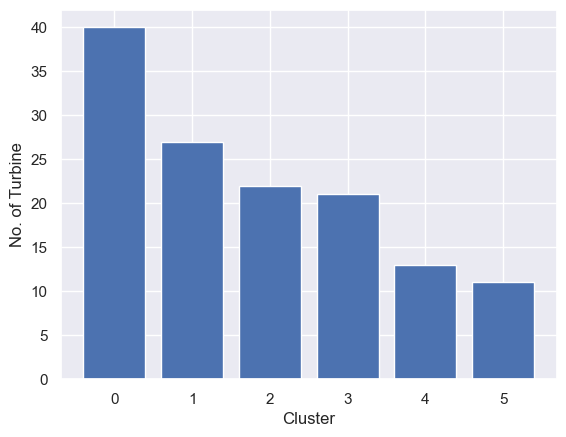

In [29]:
plt.bar(list(cluster_df['cluster'].value_counts().sort_index().index), list(cluster_df['cluster'].sort_index().value_counts()))
plt.xlabel("Cluster")
plt.ylabel("No. of Turbine")

#### The balance of the clusters is good, so I consider it as valid clustering.

In [30]:
# Assign the cluster into dataframe
cluster_df['TurbID'] = cluster_df['TurbID'] + 1
df2 = df2.merge(cluster_df, how = 'left', on = 'TurbID')

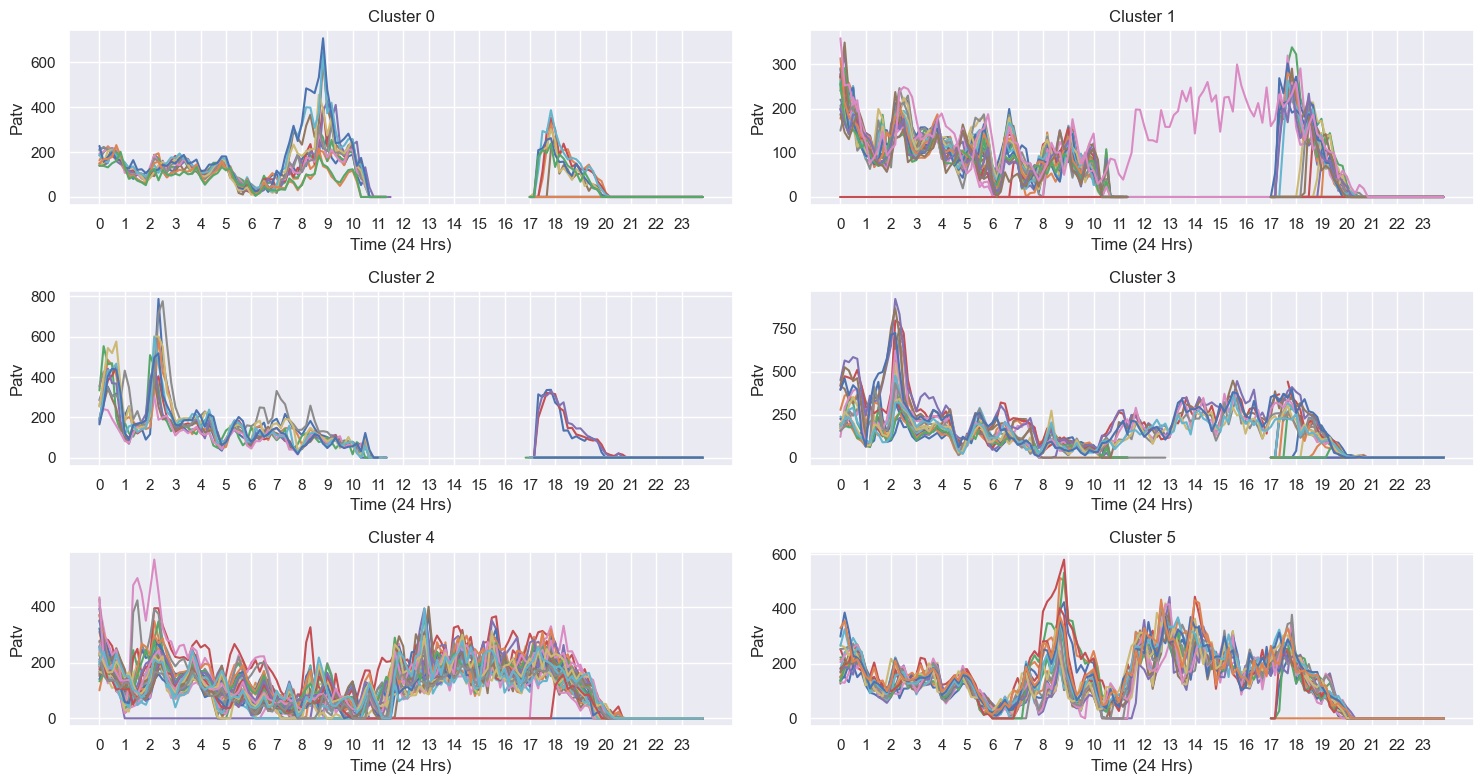

In [31]:
# General view of the Patv values by day for each cluster
day = 201
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(15, 8)
fig_list = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
time_list = df2['Hour'].unique()

for clus in range(6):
    turb_list = df2[df2['cluster']==clus]['TurbID'].unique()

    for turb in turb_list:
        axes[fig_list[clus][0], fig_list[clus][1]].plot(df2[(df2['Day']==day) & (df2['TurbID'] == turb)].reset_index()['Patv'])
        
    axes[fig_list[clus][0], fig_list[clus][1]].set_title("Cluster " + str(clus))
    axes[fig_list[clus][0], fig_list[clus][1]].set_xticks(ticks = list(range(0, 144, 6)), labels = time_list)
    axes[fig_list[clus][0], fig_list[clus][1]].set_xlabel('Time (24 Hrs)')
    axes[fig_list[clus][0], fig_list[clus][1]].set_ylabel('Patv')
    
fig.tight_layout()
plt.show()

### Other missing data

In [32]:
df2.loc[df2.isna().any(axis = 1)]

TurbID  Day  Hour  Minute  Wspd  Pab1  Pab2  Pab3  Prtv  Patv  \
0             1    1     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
1440          1   11     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
2880          1   21     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
3694          1   26    15      40   NaN   NaN   NaN   NaN   NaN   NaN   
4320          1   31     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
...         ...  ...   ...     ...   ...   ...   ...   ...   ...   ...   
4723776     134  220     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
4724496     134  225     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
4725216     134  230     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
4725936     134  235     0       0   NaN   NaN   NaN   NaN   NaN   NaN   
4726656     134  240     0       0   NaN   NaN   NaN   NaN   NaN   NaN   

         indicator  Pab_max  cluster  
0                0      NaN        2  
1440             0      NaN        2  
2880             0      NaN        2  
3694             0      NaN        2  
4320             0      NaN        2  
...            ...      ...      ...  
4723776          0      NaN        5  
4724496          0      NaN        5  
4725216          0      NaN        5  
4725936          0      NaN        5  
4726656          0      NaN        5  

[49518 rows x 13 columns]

In [33]:
# From above, we can observe the first data for each day is empty, which is making sense.
# But some of them are just missing
df2.loc[df2.isna().any(axis = 1), 'indicator'] = 1

## Overall abnormal data

In [34]:
print("Total abnormal data: " + str(df2['indicator'].value_counts()[1]))
print("Percentage: " +  str((df2['indicator'].value_counts()[1] / (len(df2['indicator'])))*100) + "%")

Total abnormal data: 1132487
Percentage: 23.955202727857312%


In [35]:
# Plot again the correlation
px.imshow(df2[df2['indicator'] == 0].drop(['indicator'], axis = 1).corr())

#### For `Patv`, both the `Wspd` and `Prtv` correlations increased

## Fill Missing / abnormal data

In [36]:
# Keep useful features only
df2.drop(['Pab1', 'Pab2', 'Pab3'], axis = 1, inplace = True)

In [37]:
# For data that have indicator, turn all of them in NA values as they are not valid
df2.loc[df2['indicator'] == 1, ['Wspd', 'Prtv', 'Patv', 'Pab_max']] = np.nan

In [38]:
# Fill the NA values with the mean of same cluster in same timestamp
df2[['TurbID', 'Wspd', 'Prtv', 'Patv', 'indicator', 'Pab_max']] = df2.groupby(['Day', 'Hour', 'Minute', 'cluster']).transform(lambda x: x.fillna(x.mean()))

In [39]:
# There are still some missing values
df2.isna().sum()

TurbID            0
Day               0
Hour              0
Minute            0
Wspd         199998
Prtv         199998
Patv         199998
indicator         0
Pab_max      199998
cluster           0
dtype: int64

In [40]:
# Use the next value to replace previous value
df2.update(df2.groupby(['TurbID', 'Day']).bfill())

In [41]:
# If there is no next value, use pervious value instead
df2.update(df2.groupby(['TurbID', 'Day']).ffill())

In [42]:
# See what's the remaining missing data
print(df2.loc[df2.isnull().any(axis = 1)]['Patv'].isna().sum())
print(df[df['Day']==66]['Patv'].isnull().sum())

19296
19296


#### From here, we can see, the whole day 66 is empty from the raw data.
#### What should we do from there? I have few ideas and do experiment on it.

#### Approach 1 ( We than take the average of Day 65 and Day 67 to replace it )

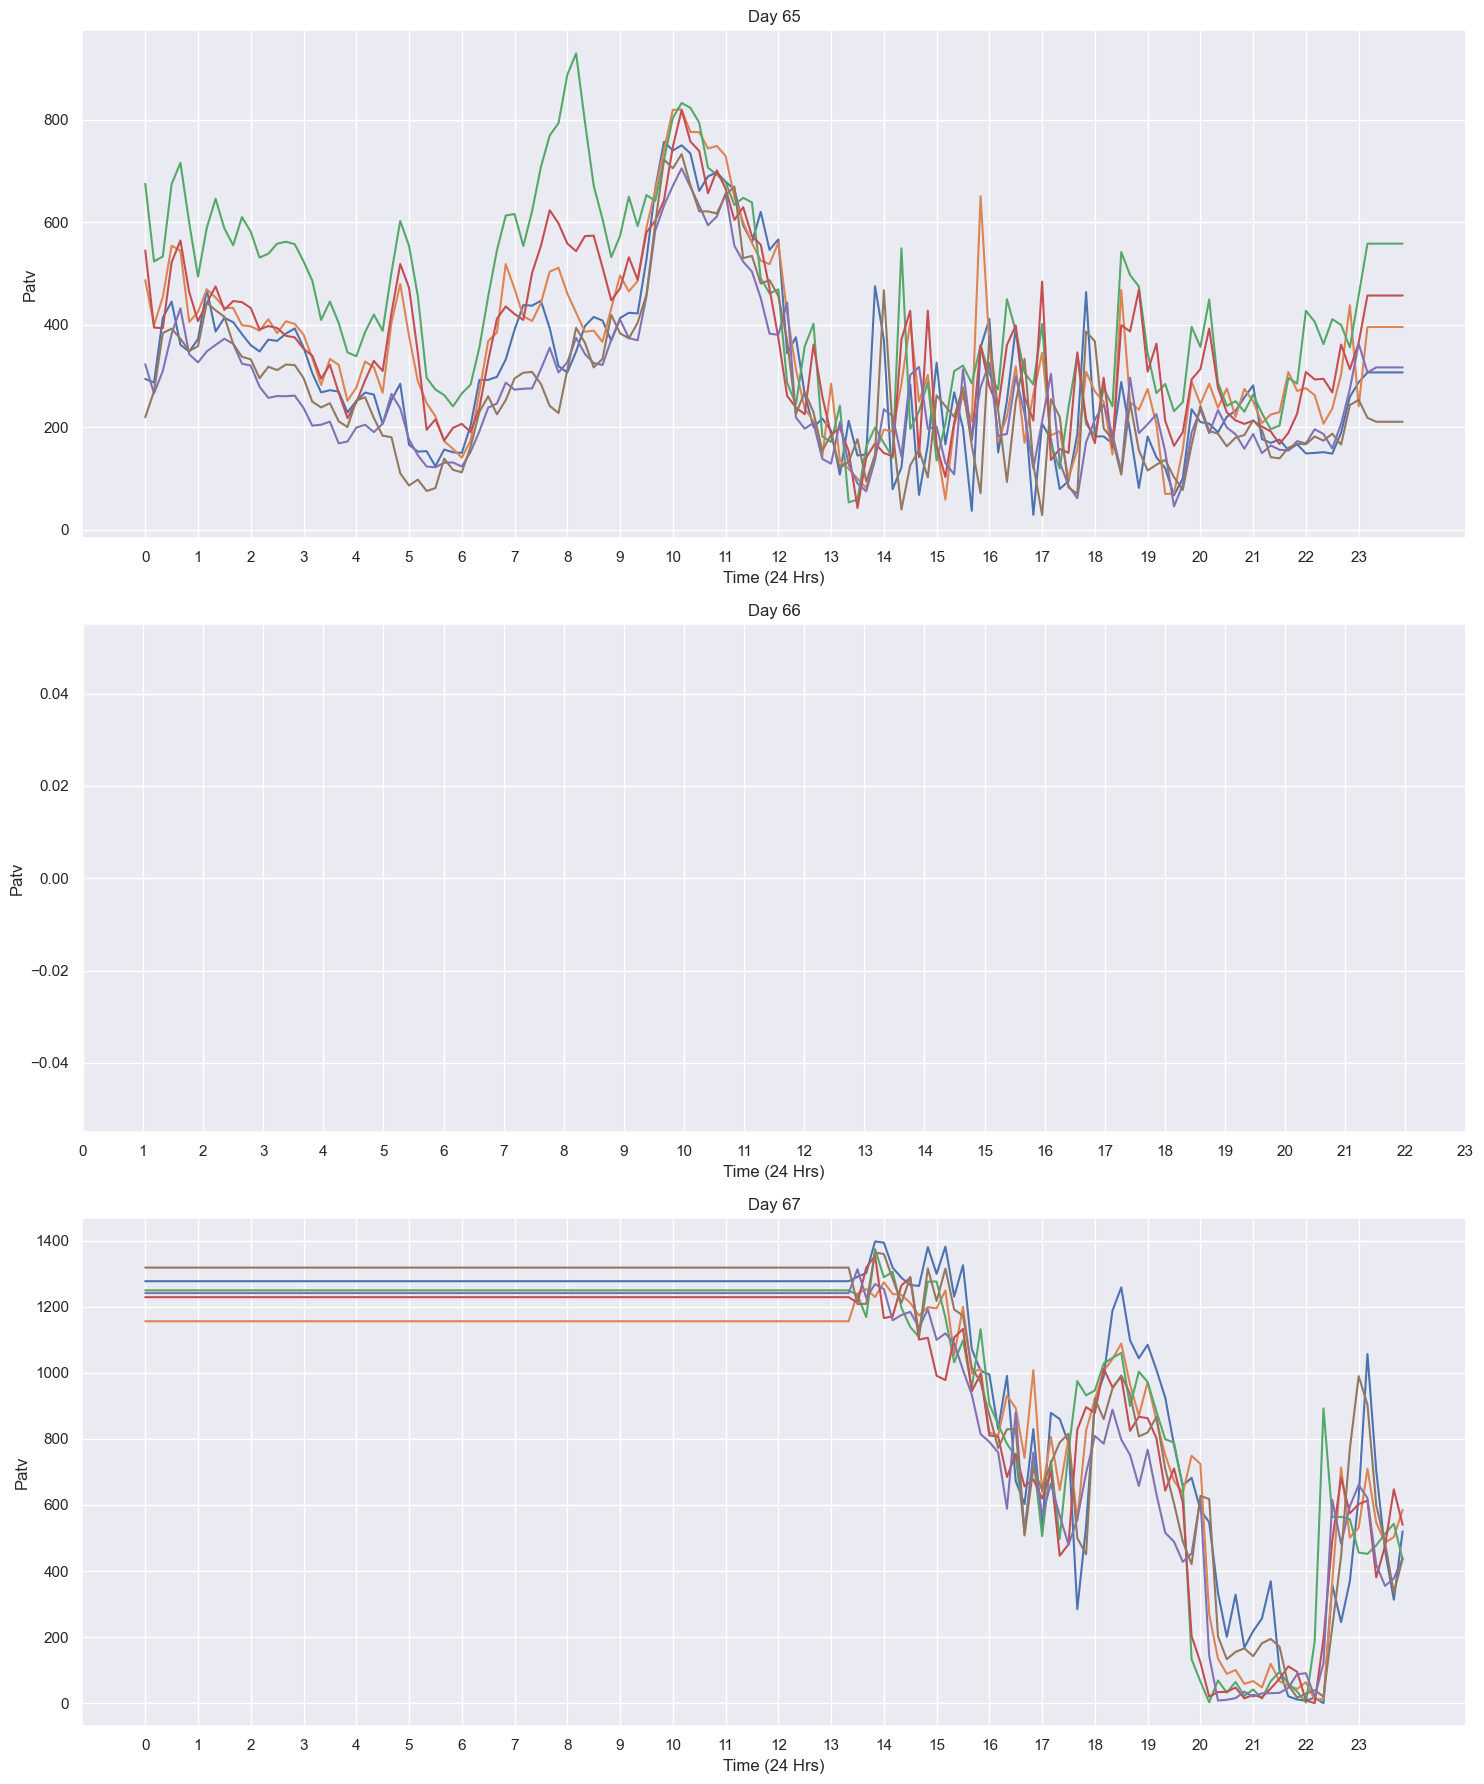

In [43]:
# General view of the Patv values by day for each cluster
start_day, end_day = 65, 67
fig, axes = plt.subplots(end_day - start_day + 1, 1)
fig.set_size_inches(15, 18)
time_list = df2['Hour'].unique()

for day in range(start_day, end_day+1):
    for clus in range(6):
        axes[day-start_day].plot(df2[(df2['Day']==day) & (df2['cluster'] == clus)].groupby(['Hour', 'Minute']).mean().reset_index()['Patv'])
        
    axes[day-start_day].set_title("Day " + str(day))
    axes[day-start_day].set_xticks(ticks = list(range(0, 144, 6)), labels = time_list)
    axes[day-start_day].set_xlabel('Time (24 Hrs)')
    axes[day-start_day].set_ylabel('Patv')
    
fig.tight_layout()
plt.show()

#### From the above plot, we can see there are some abnormal data in Day 67, so it may not be the best choice

#### Approach 2 ( We than take the average of the same weekday)

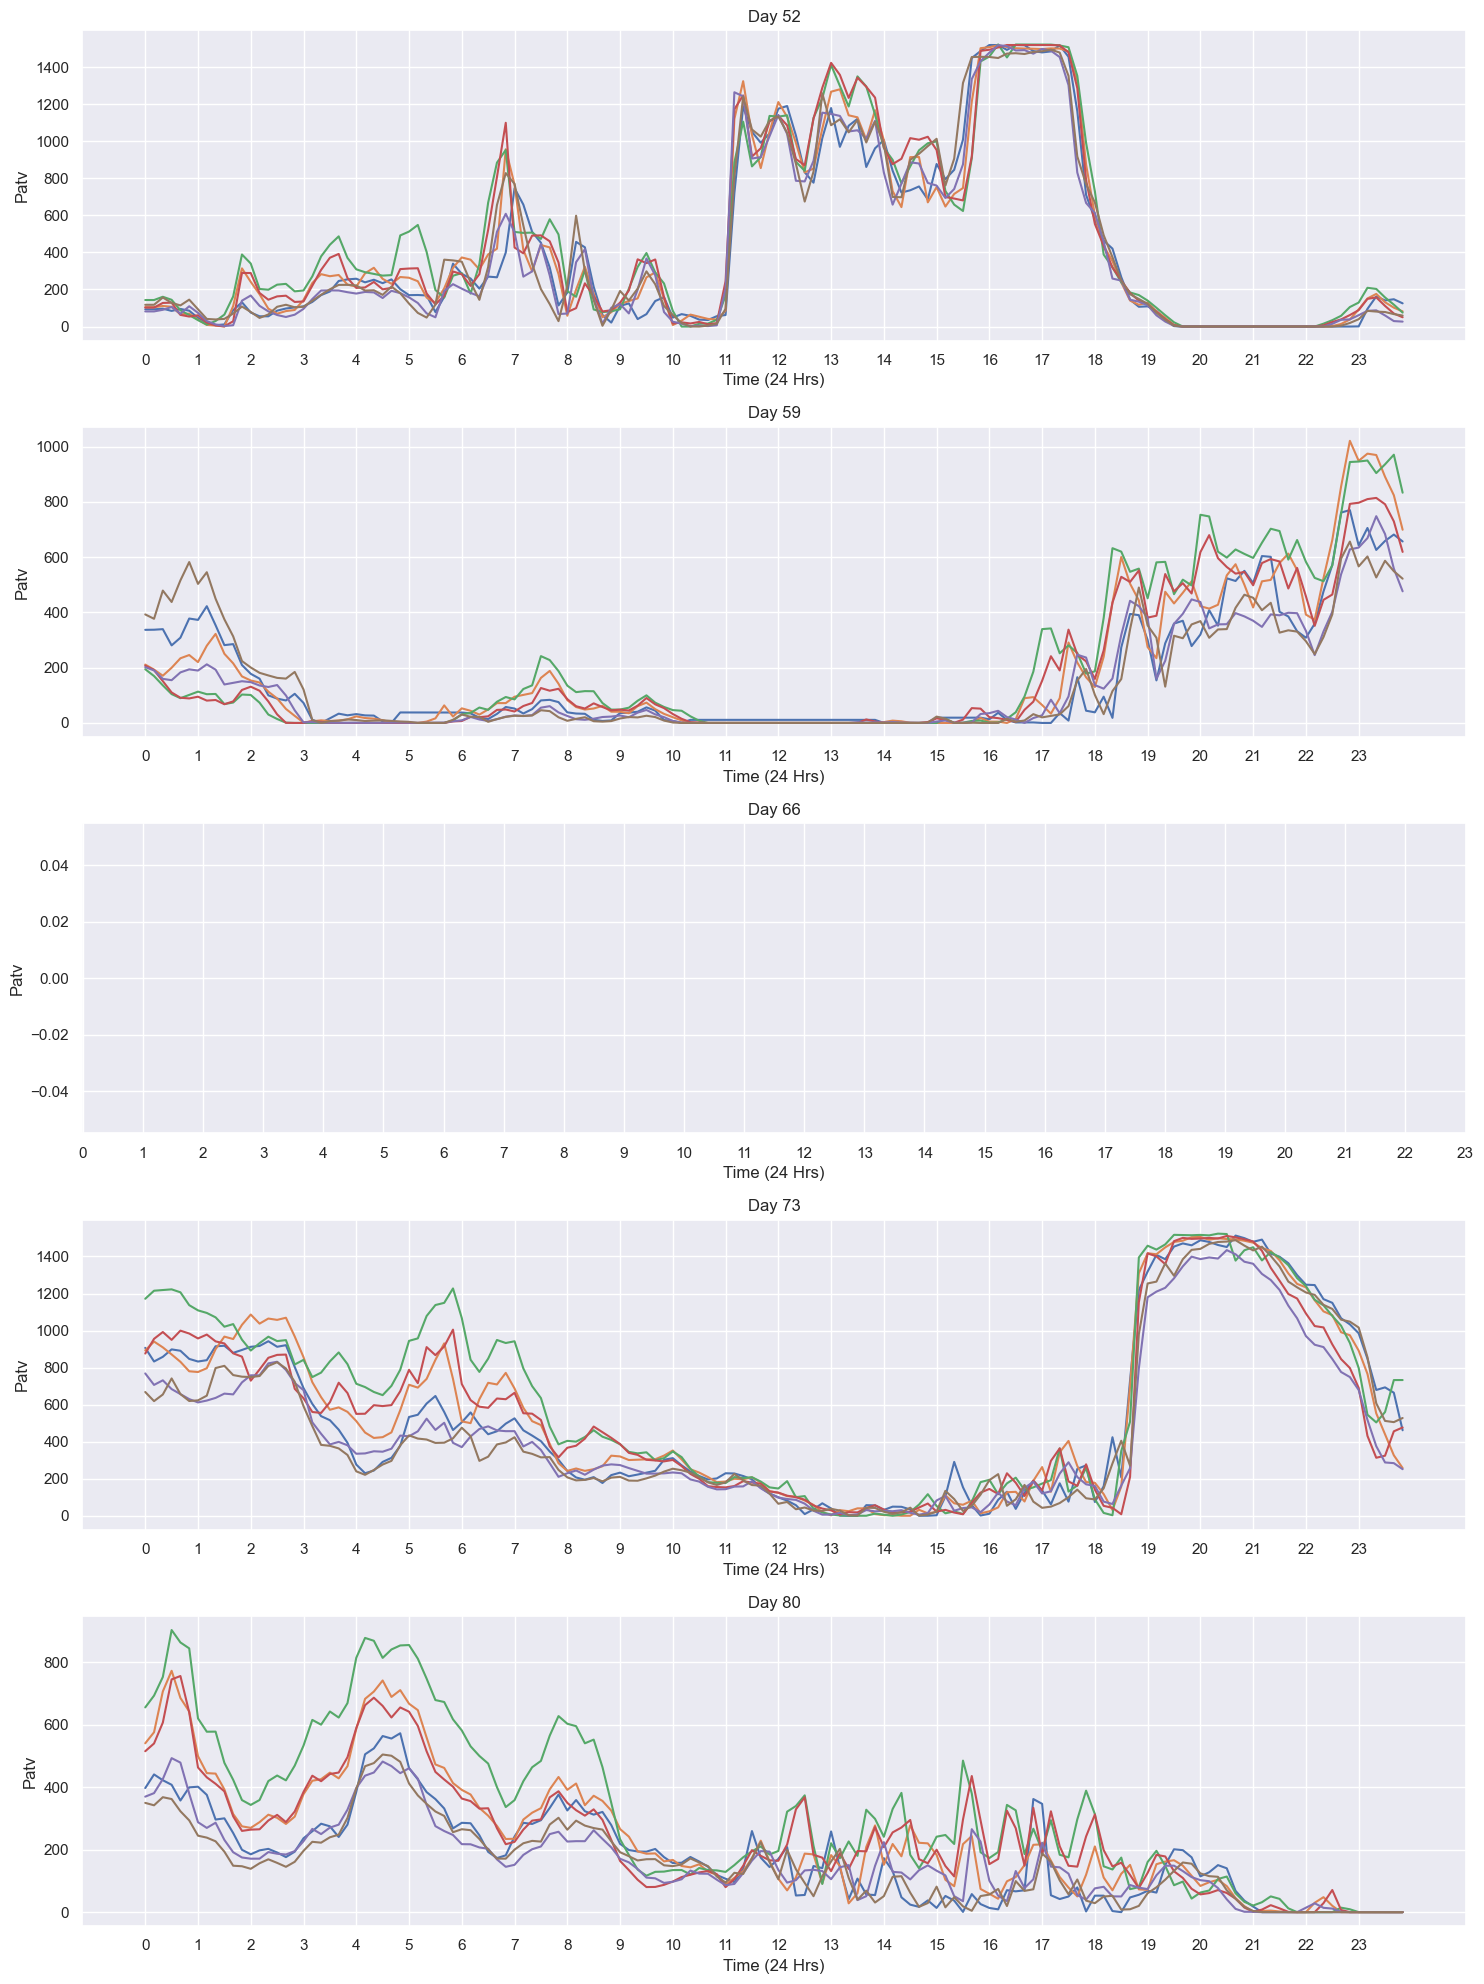

In [44]:
# General view of the Patv values by day for each cluster
start_day, end_day = 52, 80
fig, axes = plt.subplots(int((end_day - start_day + 1)/7)+1, 1)
fig.set_size_inches(15, 20)
time_list = df2['Hour'].unique()
plt_count = 0

for day in range(start_day, end_day+2, 7):
    for clus in range(6):
        axes[plt_count].plot(df2[(df2['Day']==day) & (df2['cluster'] == clus)].groupby(['Hour', 'Minute']).mean().reset_index()['Patv'])
        
    axes[plt_count].set_title("Day " + str(day))
    axes[plt_count].set_xticks(ticks = list(range(0, 144, 6)), labels = time_list)
    axes[plt_count].set_xlabel('Time (24 Hrs)')
    axes[plt_count].set_ylabel('Patv')
    plt_count += 1
    
fig.tight_layout()
plt.show()

#### As we can see above, there are different patterns on differnet days. We try to do a clustering to match the `Day` instead of `TurbID`.

#### Approach 3

In [45]:
# Convert dataframe into dimension of Day and Patv
day_df = df2.groupby(['Day', 'Hour', 'Minute'])['Patv'].mean().reset_index().drop(['Hour', 'Minute'], axis = 1).groupby('Day')['Patv'].apply(lambda df: df.reset_index(drop=True)).unstack()

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 23.42it/s]


Text(0.5, 1.0, 'Elbow Plot')

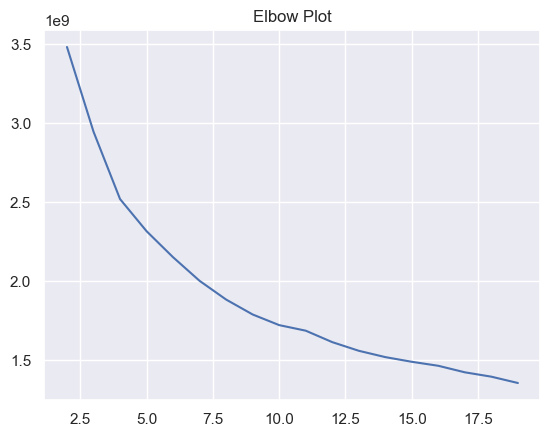

In [46]:
wcss = []
for clus in tqdm(range(2, 20)):
    kmean = KMeans(n_clusters=clus, random_state=42)
    output = kmean.fit(day_df.fillna(day_df.mean().mean())) # replace na by overall mean just for clustering 
    wcss.append(output.inertia_)
    
plt.plot(list(range(2, len(wcss)+2)), wcss)
plt.title("Elbow Plot")

In [47]:
# From the elbow plot, seems clustering the Turbine into 4, 7 groups are the best.

# 14 clusters
kmean = KMeans(n_clusters=14, random_state=42)
output = kmean.fit(day_df.fillna(day_df.mean().mean()))

day_df['cluster'] = output.labels_
day_df.reset_index(inplace = True)

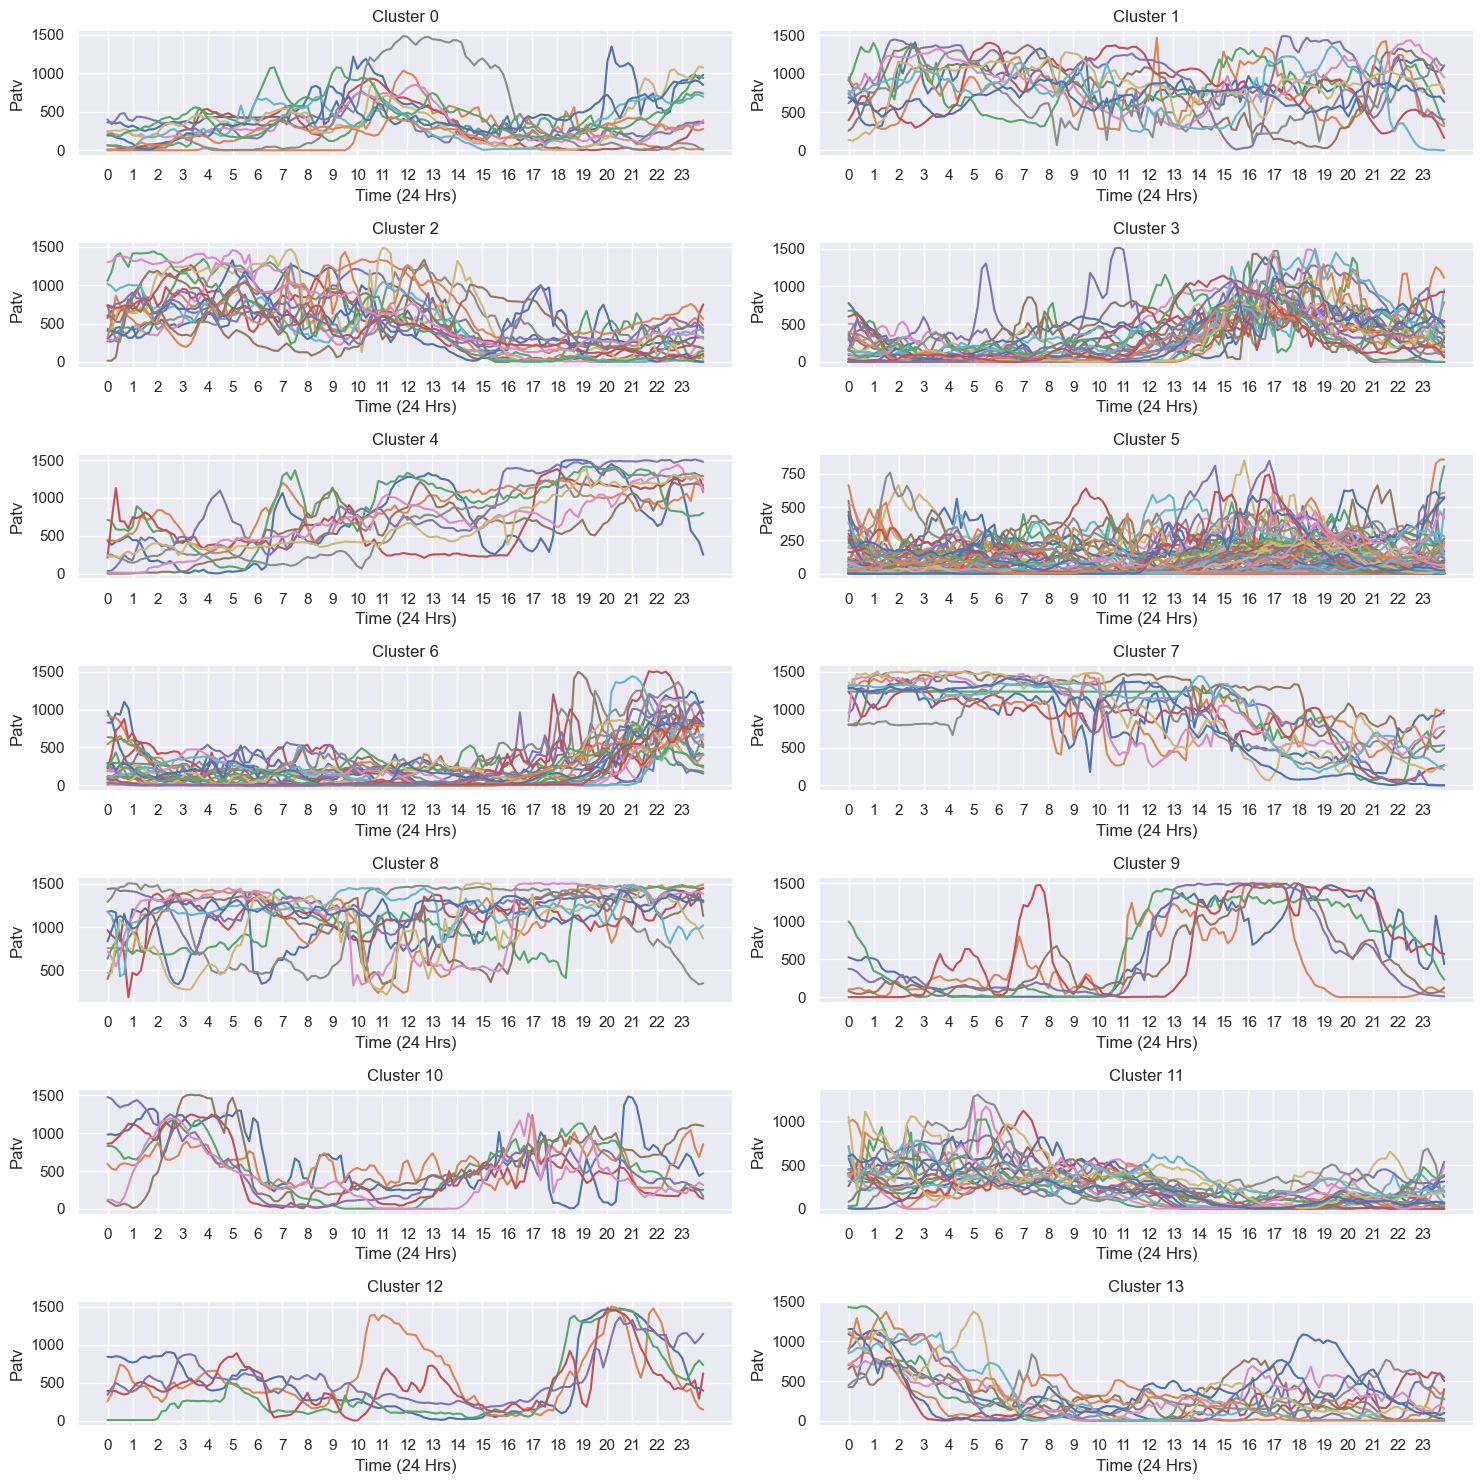

In [48]:
# General view of the Patv values by day for each cluster
fig, axes = plt.subplots(7, 2)
fig.set_size_inches(15, 15)
fig_list = [(x, y) for x in range(len(axes)) for y in range(len(axes[x]))]
time_list = df2['Hour'].unique()

for clus in range((fig_list[-1][0]+1) * (fig_list[-1][1]+1)):
    day_list = day_df[day_df['cluster']==clus]['Day'].unique()

    for day in day_list:
        axes[fig_list[clus][0], fig_list[clus][1]].plot(day_df[(day_df['Day']==day)].drop(['Day', 'cluster'], axis = 1).T)
        
    axes[fig_list[clus][0], fig_list[clus][1]].set_title("Cluster " + str(clus))
    axes[fig_list[clus][0], fig_list[clus][1]].set_xticks(ticks = list(range(0, 144, 6)), labels = time_list)
    axes[fig_list[clus][0], fig_list[clus][1]].set_xlabel('Time (24 Hrs)')
    axes[fig_list[clus][0], fig_list[clus][1]].set_ylabel('Patv')
    
fig.tight_layout()
plt.show()

#### Can we find patterns on that? Assume they have trends, the cluster come first should be assigned first.

In [49]:
reorder_dict = {y:x for x, y in enumerate(day_df['cluster'].unique())}

In [50]:
day_df['cluster'] = day_df['cluster'].apply(lambda x: reorder_dict[x])

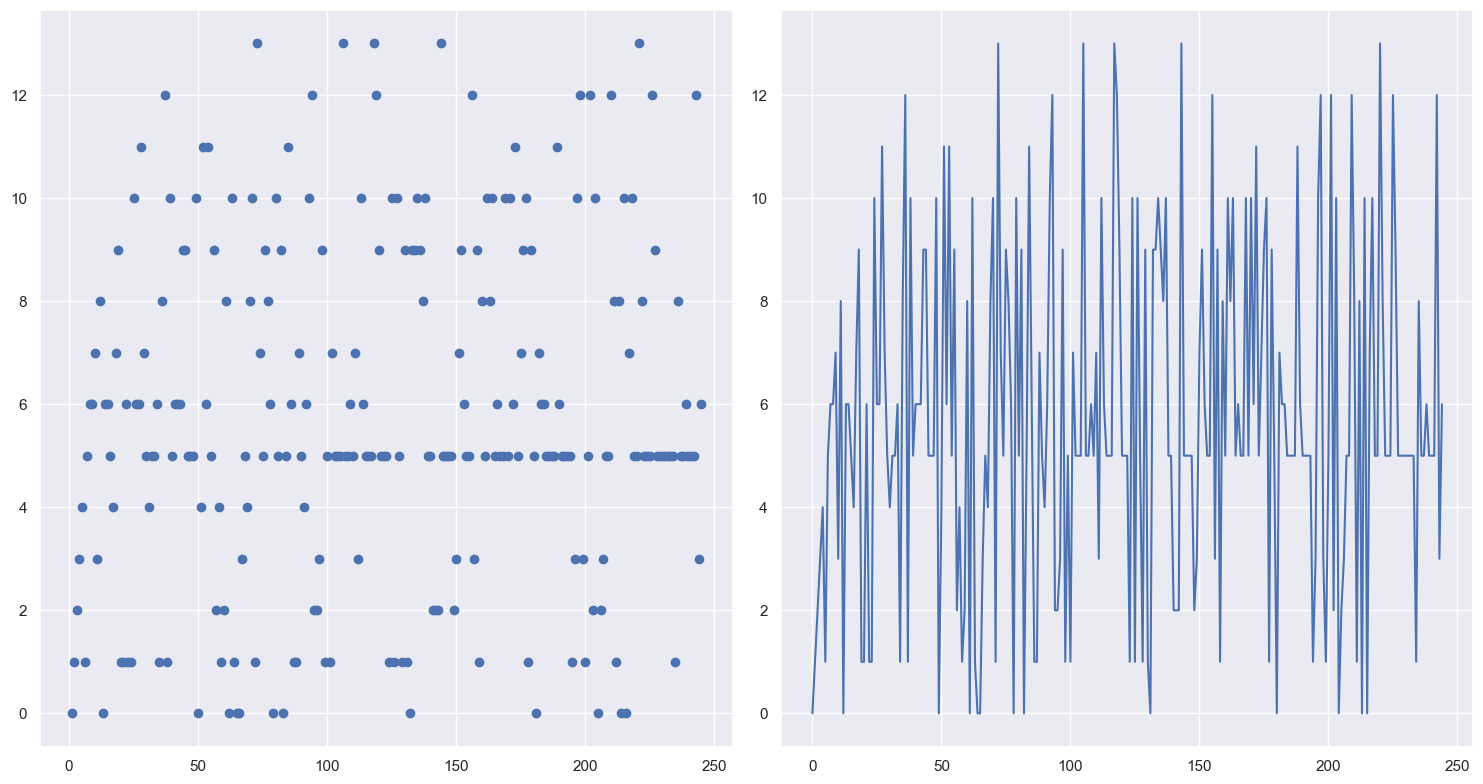

In [51]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
axes[0].scatter(x = day_df['Day'], y = day_df['cluster'])
axes[1].plot(day_df['cluster'])

fig.tight_layout()
plt.show()

#### The patterns are kind of random so we are not able to tell clearly. 
#### Can we spot the trend before and after Day 66?

In [52]:
print("Day 64 belongs to Cluster:", int(day_df[day_df['Day'] == 64]['cluster']))
print("Day 65 belongs to Cluster:", int(day_df[day_df['Day'] == 65]['cluster']))
print("Day 66 belongs to Cluster:", int(day_df[day_df['Day'] == 66]['cluster']), "(Target)")
print("Day 67 belongs to Cluster:", int(day_df[day_df['Day'] == 67]['cluster']))
print("Day 68 belongs to Cluster:", int(day_df[day_df['Day'] == 68]['cluster']))

Day 64 belongs to Cluster: 1
Day 65 belongs to Cluster: 0
Day 66 belongs to Cluster: 0 (Target)
Day 67 belongs to Cluster: 3
Day 68 belongs to Cluster: 5


#### Can we find other patterns like (1 > 10 > X > 3 > 5) or (10 > X > 3)?

In [53]:
cluster_1_index = list(day_df[day_df['cluster'] == 1].index)
cluster_10_index = list(day_df[day_df['cluster'] == 10].index)

In [54]:
print("Pattern for 5 days:")
for idx in cluster_1_index:
    try:
        n = list(day_df.iloc[idx:idx+5]['cluster'])
        if n[0] == 1 and n[1] == 10 and n[3] == 3 and n[4] == 5:
            print(n)
    except:
        pass
    
print("Pattern for 3 days:")
for idx in cluster_10_index:
    try:
        n = list(day_df.iloc[idx:idx+3]['cluster'])
        if n[0] == 10 and n[2] == 3:
            print(n) 
    except:
        pass

Pattern for 5 days:
Pattern for 3 days:
[10, 12, 3]


#### The only pattern we can search is 10 > 12 > 3.
#### So just use the mean of cluster 12 to fill Day 66

In [55]:
day_df.rename(columns = {"cluster":"day_cluster"}, inplace=True)
df2.rename(columns = {"cluster":"turb_cluster"}, inplace=True)

In [56]:
# Set Day 16 to cluster 12
day_df.at[day_df[day_df['Day']==66].index[0], 'day_cluster'] = 12

In [57]:
df2 = df2.merge(day_df[['Day', 'day_cluster']], how='left', on='Day')

In [58]:
df2 = df2.groupby(["day_cluster", "Hour", "Minute"]).transform(lambda x: x.fillna(x.mean()))

## Training data generation

In [225]:
df2

TurbID  Day  Wspd  Prtv     Patv  indicator  Pab_max  turb_cluster
0             1    1  6.17   0.0   494.66          1     1.00             2
1             1    1  6.17   0.0   494.66          0     1.00             2
2             1    1  6.27   0.0   509.76          0     1.00             2
3             1    1  6.42   0.0   542.53          0     1.00             2
4             1    1  6.25   0.0   509.36          0     1.00             2
...         ...  ...   ...   ...      ...        ...      ...           ...
4727515     134  245  7.79   0.0   601.44          0     6.03             5
4727516     134  245  8.06   0.0   673.79          0     5.81             5
4727517     134  245  8.08   0.0   999.36          0     0.68             5
4727518     134  245  8.46   0.0  1100.89          0     0.02             5
4727519     134  245  8.68   0.0  1181.49          0     0.01             5

[4727520 rows x 8 columns]

In [59]:
# Keep training variables
final_df = df2.drop(['indicator'], axis = 1)

# Make Turb Cluster into dummy variable
final_df['turb_cluster'] = final_df['turb_cluster'].astype('object')
final_df = pd.get_dummies(final_df, prefix='cluster')

In [224]:
# final_df.to_csv("final_df.csv")

In [191]:
# Define data generator to optimize memory storage
def data_generator(data, window_day, window_interval):
    num_samples = len(data)
    step_size = window_day * 144
    turb_list = final_df['TurbID'].unique()
    
    for turb in turb_list:
        for idx in range(0, 35280 - (144 * (2 + window_day)), window_interval*144):
            batch_data = data[(data['TurbID']==turb)].drop(['TurbID', 'Day'], axis = 1).reset_index(drop=True).iloc[idx:idx+step_size]
            batch_labels = data[(data['TurbID']==turb)].reset_index(drop=True).iloc[idx+step_size:idx+step_size+288]['Patv']
            
            yield np.array(batch_data), np.array(batch_labels)

In [211]:
# Adjust data generation parameters
window_day = 7  
window_interval = 2

In [213]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Define simple GRU model
def create_model(input_shape, hidden_units, output_units):
    model = keras.Sequential()
    model.add(keras.layers.GRU(hidden_units, input_shape=input_shape))
    model.add(keras.layers.Dense(output_units, activation='relu'))
    return model


# Specify the input shape, hidden units, and output units
input_shape = (int(144*window_day), 10)
hidden_units = 128
output_units = 288

# Create the model
model = create_model(input_shape, hidden_units, output_units)

# Define the loss function and optimizer
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Turn generator into Tensorflow Dataset to faster training process
dataset = tf.data.Dataset.from_generator(lambda: data_generator(final_df, window_day, window_interval), output_signature=(tf.TensorSpec(shape=(1008, 10), dtype=tf.int32), tf.TensorSpec(shape=(288,), dtype=tf.int32)))
dataset_size = len([x for x in range(0, 35280 - (144 * (2 + window_day)), window_interval*144)]) * 134
dataset.shuffle(dataset_size)

# Split the dataset into training and validation sets
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Define batch sizes
batch_size = 32

# Create batched versions of the datasets
train_dataloader = train_dataset.batch(batch_size)
val_dataloader = val_dataset.batch(batch_size)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)

# Train the model
history = model.fit(train_dataloader, validation_data=val_dataloader, epochs=100, callbacks=[early_stopping] )

Epoch 1/100
396/396 [==============================] - 420s 1s/step - loss: 308136.2812 - mae: 363.0644 - rmse: 555.1005 - val_loss: 247612.5625 - val_mae: 320.5859 - val_rmse: 497.6068
Epoch 2/100
396/396 [==============================] - 416s 1s/step - loss: 280072.0000 - mae: 344.9442 - rmse: 529.2183 - val_loss: 225221.4688 - val_mae: 307.2126 - val_rmse: 474.5751
Epoch 3/100
396/396 [==============================] - 415s 1s/step - loss: 257546.7188 - mae: 333.5914 - rmse: 507.4904 - val_loss: 207778.9844 - val_mae: 299.4560 - val_rmse: 455.8278
Epoch 4/100
396/396 [==============================] - 413s 1s/step - loss: 239770.6094 - mae: 327.1897 - rmse: 489.6636 - val_loss: 194510.0000 - val_mae: 296.2528 - val_rmse: 441.0329
Epoch 5/100
396/396 [==============================] - 417s 1s/step - loss: 226024.0000 - mae: 324.5127 - rmse: 475.4199 - val_loss: 184736.7656 - val_mae: 296.3839 - val_rmse: 429.8102
Epoch 6/100
396/396 [==============================] - 414s 1s/step - 

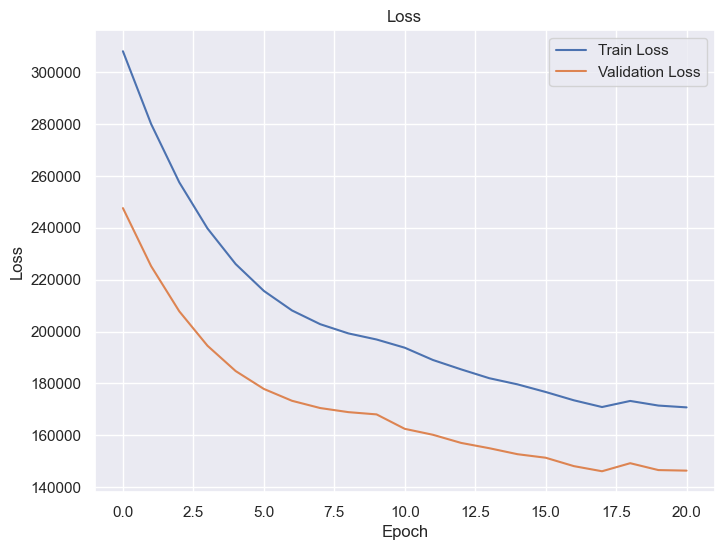

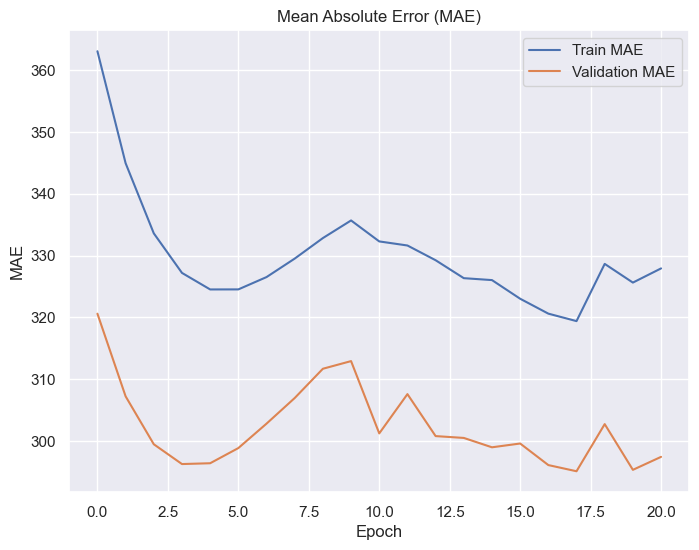

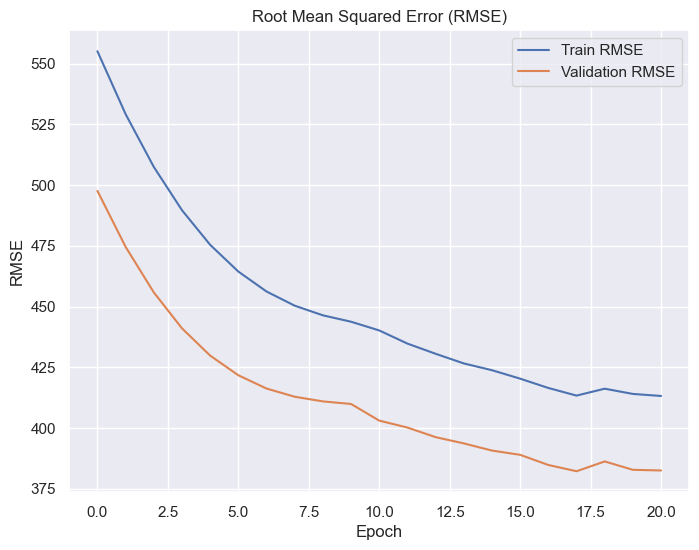

In [215]:
# Get the loss, MAE, and RMSE values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the MAE
plt.figure(figsize=(8, 6))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plot the RMSE
plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Testing

In [216]:
def evaluation(pred, label):
    pred = pred/1000
    label = label/1000
    mse = np.mean((pred - label)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(pred - label))
    
    return mae, rmse

#### Pre-process the X test

In [328]:
test_x = pd.read_csv("0001in.csv")
test_y = pd.read_csv("0001out.csv")

In [329]:
test_x = test_x[test_x['Day']>=8]

test_x.update(test_x.groupby(['TurbID', 'Day']).bfill())
test_x.update(test_x.groupby(['TurbID', 'Day']).ffill())

test_x = test_x.fillna(test_x.mean())

test_x = test_x.merge(cluster_df, how = 'left', on = 'TurbID')

test_x['Pab_max'] = test_x[['Pab1','Pab2','Pab3']].max(axis = 1)

test_x = test_x[['TurbID', 'Day', 'Wspd', 'Prtv', 'Patv', 'Pab_max', 'cluster']]

In [330]:
test_x['cluster'] = test_x['cluster'].astype('object')
test_x = pd.get_dummies(test_x, prefix='cluster')

#### Pre-process the Y test

In [331]:
test_y['indicator'] = 0

In [332]:
test_y.loc[test_y.isna().any(axis = 1), 'indicator'] = 1

In [333]:
test_y['Pab_max'] = test_y[['Pab1','Pab2','Pab3']].max(axis = 1)
test_y.loc[test_y['Pab_max'] > 89, 'indicator'] = 1
test_y.loc[(test_y['Patv'] >= 10) & (test_y['Wspd'] < 1), 'indicator'] = 1
test_y.loc[(test_y['Patv'] >= 100) & (test_y['Wspd'] < 2), 'indicator'] = 1
test_y.loc[(test_y['Patv'] >= 200) & (test_y['Wspd'] < 3), 'indicator'] = 1
test_y.loc[(test_y['Patv'] <= 0) & (test_y['Wspd'] > 2.5), 'indicator'] = 1

In [334]:
test_y = test_y.fillna(0)

# Evaluation

In [335]:
# Clean Abnormal data

In [342]:
mae_list = []
rmse_list = []

for turb in tqdm(test_x['TurbID'].unique()):
    x = np.expand_dims(np.array(test_x[test_x['TurbID'] == turb].drop(['TurbID', 'Day'], axis = 1)), axis=0)
    y = test_y[test_y['TurbID'] == turb][['Patv', 'indicator']].reset_index()
    pred = model(x)
    pred = pred.numpy()[0]
    
    for idx, n in y.iterrows():
        if n['indicator'] == 1:
            pred[idx] = n['Patv']
    
    y = y['Patv']
    
    mae, rmse = evaluation(pred, y)
    mae_list.append(mae)
    rmse_list.append(rmse)
    
print((sum(mae_list) + sum(rmse_list)) / 2)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [01:37<00:00,  1.38it/s]

41.39593518800825


In [343]:
print("MAE:", sum(mae_list))
print("RMSE:", sum(rmse_list))
print("Overall Score", (sum(mae_list) + sum(rmse_list)) / 2)

MAE: 32.90659482126862
RMSE: 49.88527555474789
Overall Score 41.39593518800825


In [338]:
# Without Clean

In [339]:
mae_list = []
rmse_list = []

for turb in tqdm(test_x['TurbID'].unique()):
    x = np.expand_dims(np.array(test_x[test_x['TurbID'] == turb].drop(['TurbID', 'Day'], axis = 1)), axis=0)
    y = test_y[test_y['TurbID'] == turb]['Patv']
    pred = model(x)
    pred = pred.numpy()[0]
    
    mae, rmse = evaluation(pred, y)
    mae_list.append(mae)
    rmse_list.append(rmse)
    

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [01:37<00:00,  1.38it/s]


In [341]:
print("MAE:", sum(mae_list))
print("RMSE:", sum(rmse_list))
print("Overall Score", (sum(mae_list) + sum(rmse_list)) / 2)

MAE: 37.51261248290836
RMSE: 51.15323576544649
Overall Score 44.332924124177424
